In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hyundai-motor-company-stock-historical-price/005380.KS.csv
/kaggle/input/hyundai-motor-company-stock-historical-price/005380.KS_monthly.csv
/kaggle/input/hyundai-motor-company-stock-historical-price/005380.KS_weekly.csv


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
df=pd.read_csv('/kaggle/input/hyundai-motor-company-stock-historical-price/005380.KS.csv')

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,147500.0,148000.0,143500.0,144000.0,116768.625000,445332
1,2016-01-05,143000.0,145000.0,142000.0,143500.0,116363.171875,530496
2,2016-01-06,144000.0,145000.0,139000.0,140000.0,113525.015625,769406
3,2016-01-07,138500.0,140000.0,137500.0,137500.0,111497.804688,586187
4,2016-01-08,134500.0,138000.0,133500.0,136500.0,110686.914062,888701


In [5]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1949,2023-12-11,185400.0,185400.0,184000.0,185400.0,185400.0,218073
1950,2023-12-12,185500.0,186400.0,185000.0,185600.0,185600.0,332590
1951,2023-12-13,185300.0,186200.0,184400.0,185000.0,185000.0,287425
1952,2023-12-14,187000.0,187100.0,184200.0,184800.0,184800.0,760383
1953,2023-12-15,185800.0,192800.0,185200.0,192800.0,192800.0,1228522


In [6]:
df.shape

(1954, 7)

In [7]:
df1=df.reset_index()['Close']

In [8]:
df1

0       144000.0
1       143500.0
2       140000.0
3       137500.0
4       136500.0
          ...   
1949    185400.0
1950    185600.0
1951    185000.0
1952    184800.0
1953    192800.0
Name: Close, Length: 1954, dtype: float64

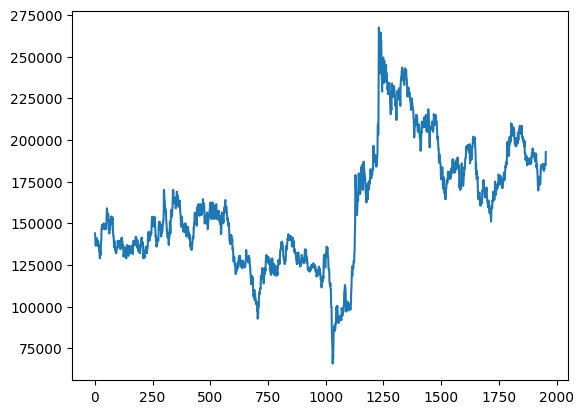

In [9]:
plt.plot(df1)

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [11]:
print(df1)

[[0.38740079]
 [0.38492063]
 [0.36755952]
 ...
 [0.59077381]
 [0.58978175]
 [0.62946429]]


In [12]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.7)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [13]:
training_size,test_size

(1367, 587)

In [14]:
train_data

array([[0.38740079],
       [0.38492063],
       [0.36755952],
       ...,
       [0.79166667],
       [0.78670635],
       [0.78918651]])

In [15]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [16]:
import numpy
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [17]:
print(X_train.shape), print(y_train.shape)

(1266, 100)
(1266,)


(None, None)

In [18]:
print(X_test.shape), print(y_test.shape)

(486, 100)
(486,)


(None, None)

In [19]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [20]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [21]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 11s 233ms/step - loss: 0.0415 - val_loss: 0.0082
Epoch 2/100
20/20 [==============================] - 3s 165ms/step - loss: 0.0063 - val_loss: 0.0016
Epoch 3/100
20/20 [==============================] - 3s 167ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 4/100
20/20 [==============================] - 4s 180ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 5/100
20/20 [==============================] - 3s 165ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 6/100
20/20 [==============================] - 3s 166ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 7/100
20/20 [==============================] - 3s 164ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 8/100
20/20 [==============================] - 3s 165ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 9/100
20/20 [==============================] - 3s 167ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 10/100
20/20 [==============================] - 3s 168ms/step - loss: 0.0022 - val_l

In [24]:
import tensorflow as tf

In [25]:
tf.__version__

'2.13.0'

In [26]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

16/16 [==============================] - 1s 37ms/step


In [27]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [28]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

153353.7968151076

In [29]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

187079.52435475422

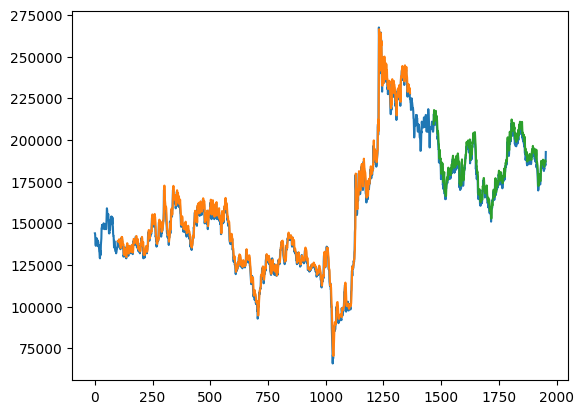

In [30]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [31]:
len(test_data)

587

In [32]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape


(1, 246)

In [33]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [34]:
temp_input

[0.4618055555555555,
 0.45188492063492064,
 0.4469246031746032,
 0.4593253968253968,
 0.45188492063492064,
 0.4568452380952381,
 0.4568452380952381,
 0.4370039682539682,
 0.42212301587301587,
 0.45188492063492064,
 0.4618055555555555,
 0.4692460317460317,
 0.4618055555555555,
 0.46428571428571425,
 0.48660714285714285,
 0.4816468253968254,
 0.48660714285714285,
 0.49900793650793646,
 0.5114087301587302,
 0.49900793650793646,
 0.49652777777777773,
 0.48908730158730157,
 0.48660714285714285,
 0.48908730158730157,
 0.4950396825396825,
 0.5416666666666667,
 0.5357142857142858,
 0.5357142857142858,
 0.5163690476190477,
 0.5014880952380953,
 0.5158730158730158,
 0.5158730158730158,
 0.5302579365079365,
 0.5188492063492063,
 0.5188492063492063,
 0.529265873015873,
 0.5322420634920635,
 0.5243055555555556,
 0.5347222222222223,
 0.5297619047619047,
 0.5625,
 0.5610119047619047,
 0.5570436507936507,
 0.5570436507936507,
 0.5372023809523809,
 0.5471230158730158,
 0.5357142857142858,
 0.5327380952

In [35]:
# demonstrate prediction for next 10 days
lst_output = []
n_steps = 100
i = 0

while i < 30:
    if len(temp_input) > 100:
        # Construct the input sequence for prediction
        x_input = np.array(temp_input[-n_steps:]).reshape((1, n_steps, 1))
        print("{} day input {}".format(i, x_input))
        
        # Make the prediction
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        
        # Update temp_input by appending the predicted value
        temp_input = temp_input + yhat[0].tolist()
        
        # Extend lst_output with the predicted value
        lst_output.extend(yhat.tolist())
        
        i = i + 1
    else:
        # If the length of temp_input is less than 100, use it as is for the first iteration
        x_input = np.array(temp_input).reshape((1, len(temp_input), 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        
        temp_input = temp_input + yhat[0].tolist()
        i = i + 1

print(lst_output)

0 day input [[[0.66517857]
  [0.66121032]
  [0.66765873]
  [0.65873016]
  [0.65426587]
  [0.64930556]
  [0.6453373 ]
  [0.66220238]
  [0.62797619]
  [0.62400794]
  [0.6264881 ]
  [0.60565476]
  [0.60763889]
  [0.61259921]
  [0.60763889]
  [0.61805556]
  [0.60962302]
  [0.59474206]
  [0.58978175]
  [0.59623016]
  [0.59623016]
  [0.60515873]
  [0.6031746 ]
  [0.59771825]
  [0.59672619]
  [0.59275794]
  [0.59920635]
  [0.6046627 ]
  [0.61111111]
  [0.60267857]
  [0.60218254]
  [0.59871032]
  [0.59920635]
  [0.60168651]
  [0.59424603]
  [0.59325397]
  [0.59672619]
  [0.61458333]
  [0.61904762]
  [0.6264881 ]
  [0.62053571]
  [0.6155754 ]
  [0.63988095]
  [0.625     ]
  [0.62301587]
  [0.62996032]
  [0.61904762]
  [0.62103175]
  [0.61954365]
  [0.61805556]
  [0.6264881 ]
  [0.60763889]
  [0.61259921]
  [0.60565476]
  [0.60119048]
  [0.59970238]
  [0.60813492]
  [0.62450397]
  [0.61011905]
  [0.58333333]
  [0.59275794]
  [0.57986111]
  [0.57589286]
  [0.56349206]
  [0.54414683]
  [0.52876984

In [36]:
# Transform predictions back to original form
predicted_values = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))

# Generate day numbers for plotting

In [37]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [38]:
len(df1)

1954

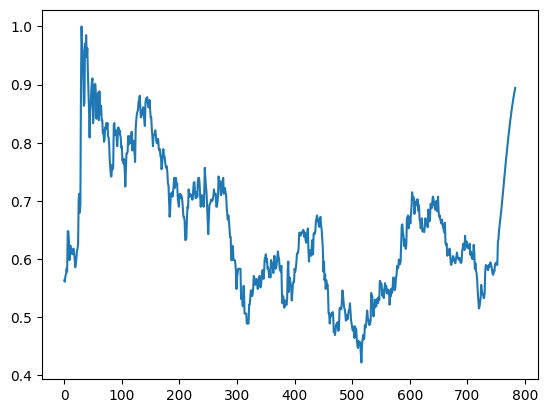

In [39]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [40]:
df3=scaler.inverse_transform(df3).tolist()

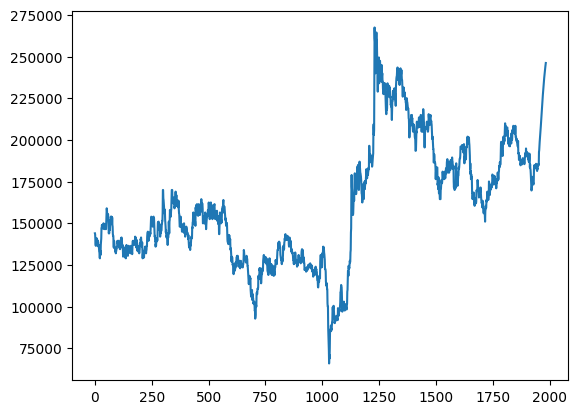

In [41]:
plt.plot(df3)